## **Análisis de Impacto Post-T-MEC**

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
pd.options.display.float_format = '{:,.2f}'.format

----

**Cargar conjunto de datos**

In [3]:
df_2012_2023 = pd.read_csv('../data/processed/mex_trade_2012_2023_clean.csv')
df_2012_2023.head(5)

,prod_est,coverage,type,year,month,concept,value_usd,status
0,Trade Balance of Goods of Mexico,National,Exports,2012,1,Total Exports,"27,281.58",Final Figures
1,Trade Balance of Goods of Mexico,National,Exports,2012,1,Petroleum,"4,628.30",Final Figures
2,Trade Balance of Goods of Mexico,National,Exports,2012,1,Crude Oil,"4,008.11",Final Figures
3,Trade Balance of Goods of Mexico,National,Exports,2012,1,Other Oil,620.18,Final Figures
4,Trade Balance of Goods of Mexico,National,Exports,2012,1,Non Petroleum,"22,653.28",Final Figures


----


**Dividir el conjunto de datos en dos periodos:**
- **Pre-T-MEC**: 2012–2019
- **Post-T-MEC**: 2020–2023

In [5]:
df_pre_tmec = df_2012_2023[df_2012_2023['year'] <= 2019].copy()
df_post_tmec = df_2012_2023[df_2012_2023['year'] >= 2020].copy()

print(f'Número de registros Pre-T-MEC (2012-2019): {len(df_pre_tmec)}')
print(f'Número de registros Post-T-MEC (2020-2023): {len(df_post_tmec)}')
print('\n')

Número de registros Pre-T-MEC (2012-2019): 1728
Número de registros Post-T-MEC (2020-2023): 828




**Comparar medias de Exportación e Importación**

In [6]:
mean_pre_tmec_exports = df_pre_tmec[df_pre_tmec['type'] == 'Exports']['value_usd'].mean()
mean_pre_tmec_imports = df_pre_tmec[df_pre_tmec['type'] == 'Imports']['value_usd'].mean()

mean_post_tmec_exports = df_post_tmec[df_post_tmec['type'] == 'Exports']['value_usd'].mean()
mean_post_tmec_imports = df_post_tmec[df_post_tmec['type'] == 'Imports']['value_usd'].mean()

print("Medias de Value_USD (Pre-T-MEC):")
print(f"  Exportaciones: {mean_pre_tmec_exports:,.2f}")
print(f"  Importaciones: {mean_pre_tmec_imports:,.2f}")
print("\nMedias de Value_USD (Post-T-MEC):")
print(f"  Exportaciones: {mean_post_tmec_exports:,.2f}")
print(f"  Importaciones: {mean_post_tmec_imports:,.2f}")
print("\n")

Medias de Value_USD (Pre-T-MEC):
  Exportaciones: 12,589.68
  Importaciones: 17,281.85

Medias de Value_USD (Post-T-MEC):
  Exportaciones: 16,168.75
  Importaciones: 22,078.47




**El T-MEC y el Aumento del Flujo Comercial en México**

Nuestro análisis comparativo de los periodos pre y post-T-MEC revela un claro incremento en el valor promedio mensual tanto de las exportaciones como de las importaciones en México. Este aumento sugiere una dinamización del comercio exterior tras la entrada en vigor del tratado.

**Crecimiento de Exportaciones e Importaciones**

Antes del T-MEC (2012-2019), el promedio mensual de las exportaciones era de $12,589.68. Post-T-MEC (2020-2023), esta cifra ascendió a $16,168.75, lo que representa un incremento de $3,579.07 (aproximadamente un 28.49%).

Por su parte, las importaciones también mostraron un alza significativa. De una media de $17,281.85 en el periodo pre-T-MEC, pasaron a $22,078.47 en el periodo post-T-MEC, un aumento de $4,796.62 (cerca del 27.75%).

**Un Aumento Absoluto Mayor en Importaciones**

Si bien ambos rubros experimentaron un crecimiento porcentual similar, es importante destacar que el incremento absoluto en el valor promedio mensual de las importaciones fue mayor ($4,796.62) que el de las exportaciones ($3,579.07). Esto sugiere que, si bien el T-MEC impulsó ambos lados de la balanza comercial, el crecimiento en el flujo de entrada de bienes fue marginalmente más pronunciado.

**Consideraciones Futuras**

Estos hallazgos iniciales son prometedores y apuntan a un efecto positivo del T-MEC en la actividad comercial de México. Sin embargo, para determinar si estas diferencias son estadísticamente significativas y si el T-MEC es el factor causal principal, será crucial apoyarse en pruebas de hipótesis más rigurosas, como las pruebas t-Student o Mann-Whitney U.

**Prueba de Hipótesis**
- H0: No hay diferencia en el valor medio antes y después.
- H1: Sí hay diferencia significativa.

In [8]:
# Nivel de significancia
alpha = 0.05

In [ ]:
# --- COMPARACIÓN PARA EXPORTACIONES ---
print("\n--- Comparación para EXPORTACIONES ---")
exports_pre_tmec = df_pre_tmec[df_pre_tmec['type'] == 'Exports']['value_usd'].dropna()
exports_post_tmec = df_post_tmec[df_post_tmec['type'] == 'Exports']['value_usd'].dropna()

if len(exports_pre_tmec) > 1 and len(exports_post_tmec) > 1:
    levene_stat_exp, p_levene_exp = stats.levene(exports_pre_tmec, exports_post_tmec)
    print(f"  Prueba de Levene (Exportaciones): Estadístico={levene_stat_exp:.4f}, p-valor={p_levene_exp:.4f}")

    equal_variances_exp = p_levene_exp >= alpha
    if equal_variances_exp:
        print("  -> Las varianzas de Exportaciones son aproximadamente iguales.")
    else:
        print("  -> Las varianzas de Exportaciones son significativamente diferentes.")
    
    if len(exports_pre_tmec) > 3 and len(exports_post_tmec) > 3:
        shapiro_pre_exp_stat, p_shapiro_pre_exp = stats.shapiro(exports_pre_tmec)
        shapiro_post_exp_stat, p_shapiro_post_exp = stats.shapiro(exports_post_tmec)
        print(f"  Normalidad Exportaciones Pre-T-MEC (Shapiro): p-valor={p_shapiro_pre_exp:.4f}")
        print(f"  Normalidad Exportaciones Post-T-MEC (Shapiro): p-valor={p_shapiro_post_exp:.4f}")

        normal_dist_exp = (p_shapiro_pre_exp >= alpha) and (p_shapiro_post_exp >= alpha)
        if normal_dist_exp:
            print("  -> Ambos grupos de Exportaciones parecen seguir una distribución normal.")
        else:
            print("  -> Al menos un grupo de Exportaciones NO parece seguir una distribución normal.")
    else:
        print("  -> No hay suficientes datos para la prueba de normalidad de Shapiro-Wilk en Exportaciones.")
        normal_dist_exp = False 

    if normal_dist_exp: 
        if equal_variances_exp:
            t_stat_exp, p_value_exp = stats.ttest_ind(exports_pre_tmec, exports_post_tmec, equal_var=True)
            test_type_exp = "T-test (varianzas iguales)"
        else:
            t_stat_exp, p_value_exp = stats.ttest_ind(exports_pre_tmec, exports_post_tmec, equal_var=False)
            test_type_exp = "T-test (varianzas desiguales - Welch)"
        print(f"  {test_type_exp} (Exportaciones): Estadístico={t_stat_exp:.4f}, p-valor={p_value_exp:.4f}")

    else: 
        u_stat_exp, p_value_exp = stats.mannwhitneyu(exports_pre_tmec, exports_post_tmec)
        test_type_exp = "Mann-Whitney U"
        print(f"  {test_type_exp} (Exportaciones): Estadístico={u_stat_exp:.4f}, p-valor={p_value_exp:.4f}")
    
    if p_value_exp < alpha:
        print(f"  CONCLUSIÓN: Rechazamos H0. Hay una diferencia significativa en la media de Exportaciones entre los periodos Pre-T-MEC y Post-T-MEC.")
    else:
        print(f"  CONCLUSIÓN: No rechazamos H0. No hay evidencia de una diferencia significativa en la media de Exportaciones entre los periodos Pre-T-MEC y Post-T-MEC.")
else:
    print("  No hay suficientes datos de Exportaciones para realizar pruebas de hipótesis.")



--- Comparación para EXPORTACIONES ---
  Prueba de Levene (Exportaciones): Estadístico=11.9396, p-valor=0.0006
  -> Las varianzas de Exportaciones son significativamente diferentes.
  Normalidad Exportaciones Pre-T-MEC (Shapiro): p-valor=0.0000
  Normalidad Exportaciones Post-T-MEC (Shapiro): p-valor=0.0000
  -> Al menos un grupo de Exportaciones NO parece seguir una distribución normal.
  Mann-Whitney U (Exportaciones): Estadístico=120006.0000, p-valor=0.0000
  CONCLUSIÓN: Rechazamos H0. Hay una diferencia significativa en la media de Exportaciones entre los periodos Pre-T-MEC y Post-T-MEC.


In [20]:
# --- COMPARACIÓN PARA IMPORTACIONES ---
print("\n--- Comparación para IMPORTACIONES ---")
imports_pre_tmec = df_pre_tmec[df_pre_tmec['type'] == 'Imports']['value_usd'].dropna()
imports_post_tmec = df_post_tmec[df_post_tmec['type'] == 'Imports']['value_usd'].dropna()

if len(imports_pre_tmec) > 1 and len(imports_post_tmec) > 1:
    levene_stat_imp, p_levene_imp = stats.levene(imports_pre_tmec, imports_post_tmec)
    print(f"  Prueba de Levene (Importaciones): Estadístico={levene_stat_imp:.4f}, p-valor={p_levene_imp:.4f}")

    equal_variances_imp = p_levene_imp >= alpha
    if equal_variances_imp:
        print("  -> Las varianzas de Importaciones son aproximadamente iguales.")
    else:
        print("  -> Las varianzas de Importaciones son significativamente diferentes.")

    if len(imports_pre_tmec) > 3 and len(imports_post_tmec) > 3:
        shapiro_pre_imp_stat, p_shapiro_pre_imp = stats.shapiro(imports_pre_tmec)
        shapiro_post_imp_stat, p_shapiro_post_imp = stats.shapiro(imports_post_tmec)
        print(f"  Normalidad Importaciones Pre-T-MEC (Shapiro): p-valor={p_shapiro_pre_imp:.4f}")
        print(f"  Normalidad Importaciones Post-T-MEC (Shapiro): p-valor={p_shapiro_post_imp:.4f}")

        normal_dist_imp = (p_shapiro_pre_imp >= alpha) and (p_shapiro_post_imp >= alpha)
        if normal_dist_imp:
            print("  -> Ambos grupos de Importaciones parecen seguir una distribución normal.")
        else:
            print("  -> Al menos un grupo de Importaciones NO parece seguir una distribución normal.")
    else:
        print("  -> No hay suficientes datos para la prueba de normalidad de Shapiro-Wilk en Importaciones.")
        normal_dist_imp = False

    if normal_dist_imp:
        if equal_variances_imp:
            t_stat_imp, p_value_imp = stats.ttest_ind(imports_pre_tmec, imports_post_tmec, equal_var=True)
            test_type_imp = "T-test (varianzas iguales)"
        else:
            t_stat_imp, p_value_imp = stats.ttest_ind(imports_pre_tmec, imports_post_tmec, equal_var=False)
            test_type_imp = "T-test (varianzas desiguales - Welch)"
        print(f"  {test_type_imp} (Importaciones): Estadístico={t_stat_imp:.4f}, p-valor={p_value_imp:.4f}")

    else:
        u_stat_imp, p_value_imp = stats.mannwhitneyu(imports_pre_tmec, imports_post_tmec)
        test_type_imp = "Mann-Whitney U"
        print(f"  {test_type_imp} (Importaciones): Estadístico={u_stat_imp:.4f}, p-valor={p_value_imp:.4f}")
    
    if p_value_imp < alpha:
        print(f"  CONCLUSIÓN: Rechazamos H0. Hay una diferencia significativa en la media de Importaciones entre los periodos Pre-T-MEC y Post-T-MEC.")
    else:
        print(f"  CONCLUSIÓN: No rechazamos H0. No hay evidencia de una diferencia significativa en la media de Importaciones entre los periodos Pre-T-MEC y Post-T-MEC.")
else:
    print("  No hay suficientes datos de Importaciones para realizar pruebas de hipótesis.")



--- Comparación para IMPORTACIONES ---
  Prueba de Levene (Importaciones): Estadístico=70.0658, p-valor=0.0000
  -> Las varianzas de Importaciones son significativamente diferentes.
  Normalidad Importaciones Pre-T-MEC (Shapiro): p-valor=0.0000
  Normalidad Importaciones Post-T-MEC (Shapiro): p-valor=0.0000
  -> Al menos un grupo de Importaciones NO parece seguir una distribución normal.
  Mann-Whitney U (Importaciones): Estadístico=113607.0000, p-valor=0.0000
  CONCLUSIÓN: Rechazamos H0. Hay una diferencia significativa en la media de Importaciones entre los periodos Pre-T-MEC y Post-T-MEC.


**El T-MEC Impulsó Significativamente el Comercio Mexicano**

Nuestro análisis estadístico confirma lo que las cifras iniciales sugerían: la entrada en vigor del T-MEC, y el período subsiguiente, marcó un cambio estadísticamente significativo en el valor promedio tanto de las exportaciones como de las importaciones en México. Esto significa que los incrementos observados en el comercio no son producto del azar, sino reflejan una verdadera transformación en la dinámica comercial del país.

**Impacto Confirmado en Exportaciones**

Las pruebas realizadas para las exportaciones demuestran contundentemente que hay una diferencia significativa en el valor promedio entre el período Pre-T-MEC y Post-T-MEC. Aunque las varianzas entre ambos periodos son distintas y los datos no siguen una distribución normal (lo que validó el uso de la prueba no paramétrica Mann-Whitney U), el p-valor extremadamente bajo nos permite rechazar la hipótesis nula. En términos prácticos, esto refuerza que el aumento de $12,589.68 a $16,168.75 en la media de las exportaciones es un cambio real y sustancial.

**Crecimiento Confirmado en Importaciones**

De manera similar, las importaciones también muestran una diferencia estadísticamente significativa en su valor promedio entre ambos períodos. Al igual que con las exportaciones, las varianzas son diferentes y los datos no se distribuyen normalmente, haciendo de la prueba Mann-Whitney U la herramienta adecuada. El p-valor igualmente bajo nos permite rechazar la hipótesis nula, confirmando que el incremento de $17,281.85 a $22,078.47 en la media de las importaciones es un cambio genuino.

**Consideraciones Clave del Análisis**

Es crucial destacar que la robustez de estas conclusiones se basa en la correcta elección de las pruebas estadísticas. El hecho de que las varianzas de los datos fueran significativamente diferentes y que no siguieran una distribución normal, llevó a la aplicación de la prueba no paramétrica de Mann-Whitney U. Esto asegura que nuestras inferencias sean válidas a pesar de las características específicas de los datos.

En resumen, los resultados no solo muestran un aumento en el comercio post-T-MEC, sino que lo validan estadísticamente, indicando que este nuevo tratado y los factores asociados a su implementación (incluyendo, posiblemente, la adaptación a los cambios globales derivados de la pandemia) han tenido un impacto real y medible en el incremento del valor promedio de las transacciones comerciales de México, tanto de entrada como de salida.

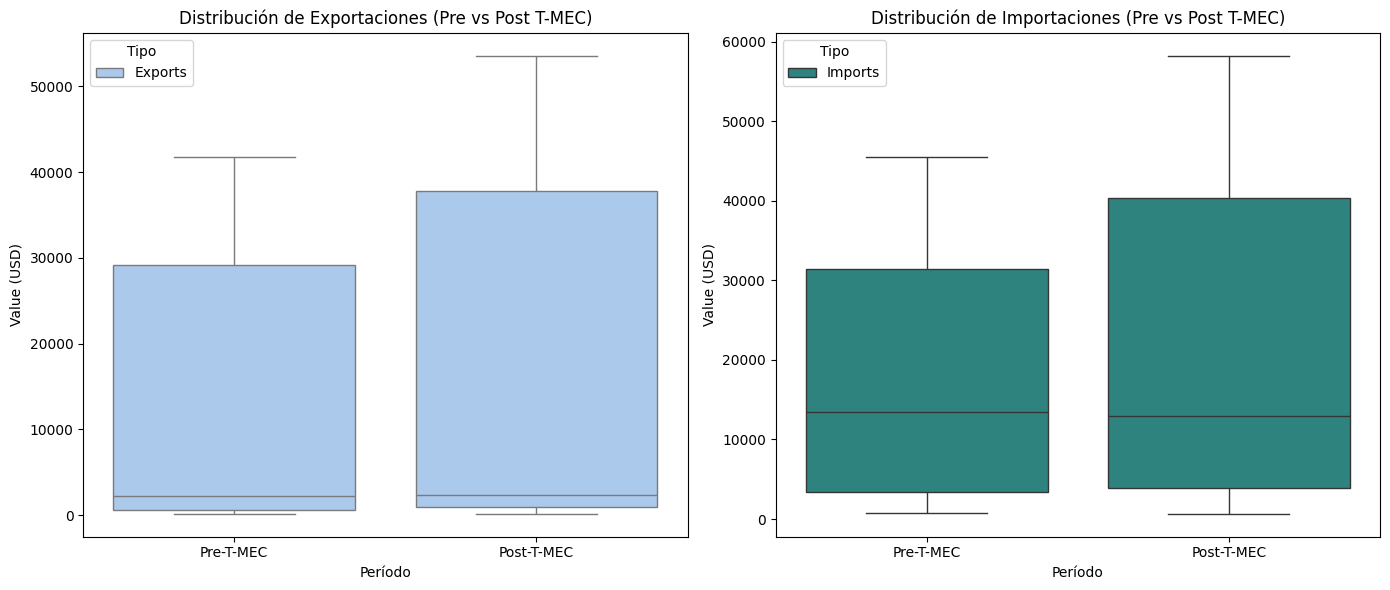

In [18]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1) # Subplot para Exportaciones
sns.boxplot(x='period', y='value_usd', data=pd.concat([
    df_pre_tmec[df_pre_tmec['type'] == 'Exports'].assign(period='Pre-T-MEC'),
    df_post_tmec[df_post_tmec['type'] == 'Exports'].assign(period='Post-T-MEC')
]), hue='type', palette='pastel')
plt.title('Distribución de Exportaciones (Pre vs Post T-MEC)')
plt.legend(title='Tipo')
plt.ylabel('Value (USD)')
plt.xlabel('Período')
plt.ticklabel_format(style='plain', axis='y') # Evitar notación científica si no es necesario

plt.subplot(1, 2, 2) # Subplot para Importaciones
sns.boxplot(x='period', y='value_usd', data=pd.concat([
    df_pre_tmec[df_pre_tmec['type'] == 'Imports'].assign(period='Pre-T-MEC'),
    df_post_tmec[df_post_tmec['type'] == 'Imports'].assign(period='Post-T-MEC')
]), hue='type',palette='viridis')
plt.title('Distribución de Importaciones (Pre vs Post T-MEC)')
plt.legend(title='Tipo')
plt.ylabel('Value (USD)')
plt.xlabel('Período')
plt.ticklabel_format(style='plain', axis='y') # Evitar notación científica si no es necesario

plt.tight_layout()
plt.show()

**Visualizando el Impacto del T-MEC en Exportaciones e Importaciones**

Los gráficos de caja (boxplots) confirman visualmente las conclusiones estadísticas previas, mostrando una clara diferencia en la distribución de los valores de exportaciones e importaciones entre el período Pre-T-MEC y Post-T-MEC.

**Exportaciones: Un Salto Cuantitativo Post-T-MEC**
El gráfico de caja de Exportaciones ilustra un aumento notable en el valor.

* ***Pre-T-MEC:*** La caja es más compacta y se sitúa en un rango de valores más bajos. La mediana (línea dentro de la caja) es relativamente baja, lo que indica que la mayoría de las exportaciones se concentraban en valores menores.
* ***Post-T-MEC:*** La caja se desplaza significativamente hacia arriba y es considerablemente más grande, lo que sugiere no solo un aumento en la mediana (valor central) de las exportaciones, sino también una mayor variabilidad o dispersión en los valores. Esto refuerza la idea de que, después del T-MEC, hubo un incremento generalizado en el valor de las exportaciones.

**Importaciones: Crecimiento y Mayor Amplitud**

El gráfico de caja de Importaciones refleja un patrón similar de crecimiento.

* ***Pre-T-MEC:*** La caja se encuentra en un rango intermedio, con una mediana ya más alta que la de las exportaciones en el mismo período.
* ***Post-T-MEC:*** Al igual que con las exportaciones, la caja de las importaciones se desplaza visiblemente hacia arriba, indicando un aumento en su mediana y en el rango de valores. Esto es consistente con el incremento absoluto más grande en las medias de importaciones que observamos estadísticamente. La mayor altura de la caja también sugiere una mayor dispersión en los valores de importación después del T-MEC.

**Conclusión Visual**

En conjunto, ambos gráficos de caja proporcionan una evidencia visual contundente de que tanto las exportaciones como las importaciones experimentaron un incremento en sus valores promedio y, en algunos casos, una mayor variabilidad en el período posterior a la implementación del T-MEC. Esto refuerza las conclusiones obtenidas de las pruebas de hipótesis, demostrando que los cambios observados son significativos y tangibles en la distribución de los datos.